In [4]:
# Imports:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [5]:
# Load Datasets:
df1 = pd.read_csv("Medical_insurance.csv")
df2 = pd.read_csv("insurance.csv")

In [6]:
# Merge datasets
df = pd.concat([df1, df2], ignore_index=True)
# Display basic info
print(df.info())
print(df.head())
# Save merged dataset
df.to_csv("merged_medical_insurance.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4110 entries, 0 to 4109
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       4110 non-null   int64  
 1   sex       4110 non-null   object 
 2   bmi       4110 non-null   float64
 3   children  4110 non-null   int64  
 4   smoker    4110 non-null   object 
 5   region    4110 non-null   object 
 6   charges   4110 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 224.9+ KB
None
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


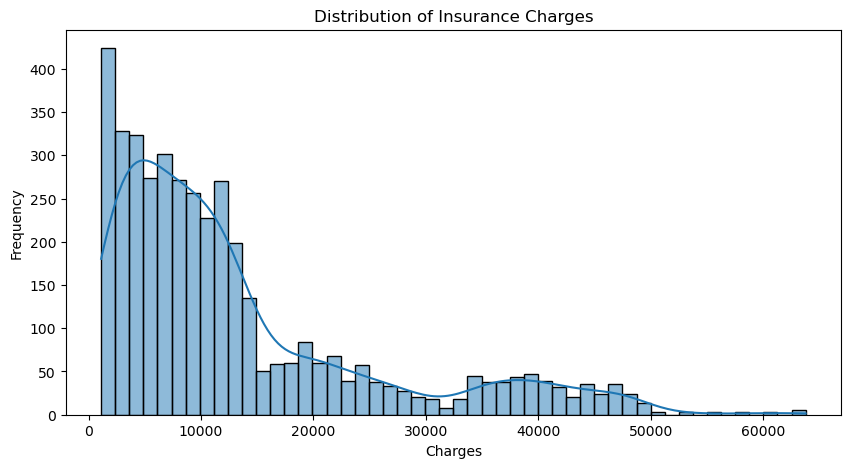

In [7]:
# Distribution of insurance charges
plt.figure(figsize=(10, 5))
sns.histplot(df['charges'], bins=50, kde=True)
plt.title("Distribution of Insurance Charges")
plt.xlabel("Charges")
plt.ylabel("Frequency")
plt.show()

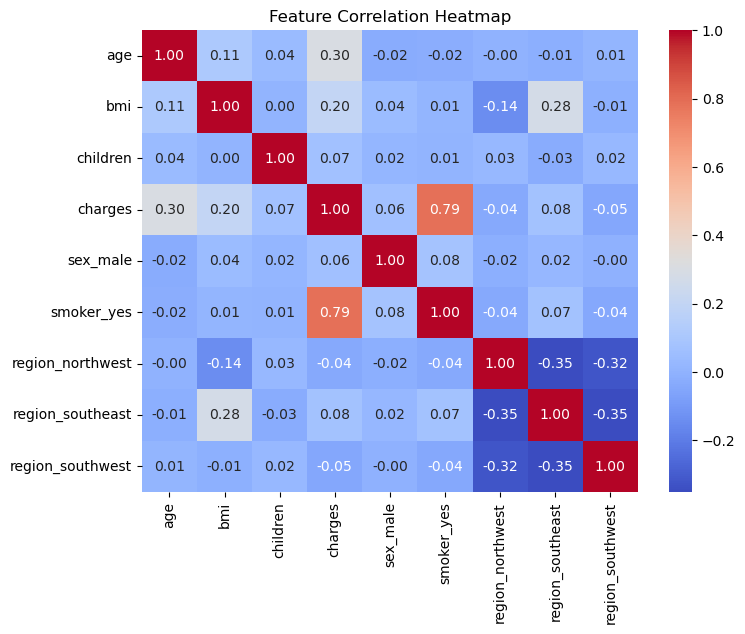

In [8]:
# Correlation Heatmap
df_encoded = df.copy()
categorical_features = ['sex', 'smoker', 'region']
df_encoded = pd.get_dummies(df_encoded, columns=categorical_features, drop_first=True)
plt.figure(figsize=(8, 6))
sns.heatmap(df_encoded.corr(), annot=True, cmap="coolwarm", fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

Missing values:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


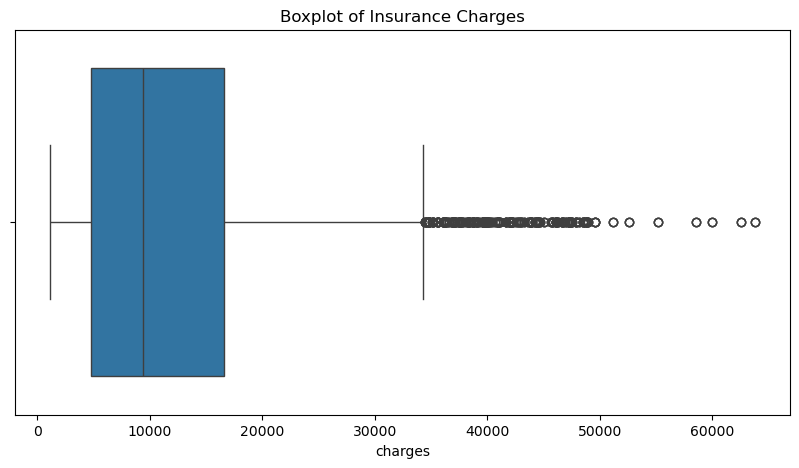

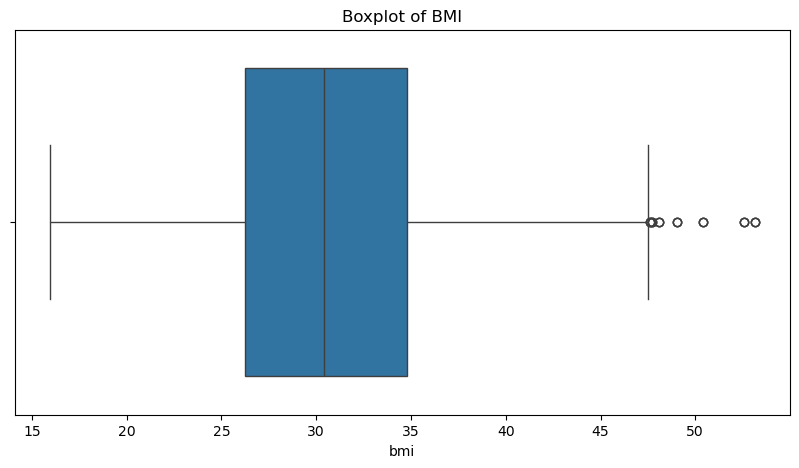

In [9]:
print("Missing values:\n", df.isnull().sum())

# Detect outliers using box plots
plt.figure(figsize=(10, 5))
sns.boxplot(x=df["charges"])
plt.title("Boxplot of Insurance Charges")
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x=df["bmi"])
plt.title("Boxplot of BMI")
plt.show()

In [10]:
# Create BMI categories
df["bmi_category"] = pd.cut(df["bmi"], bins=[0, 18.5, 24.9, 29.9, 50], 
                            labels=["Underweight", "Normal", "Overweight", "Obese"])
print(df[["bmi", "bmi_category"]].head())

      bmi bmi_category
0  27.900   Overweight
1  33.770        Obese
2  33.000        Obese
3  22.705       Normal
4  28.880   Overweight


In [11]:
# One-hot encoding categorical variables
df = pd.get_dummies(df, columns=["sex", "smoker", "region", "bmi_category"], drop_first=True)
print(df.head())

   age     bmi  children      charges  sex_male  smoker_yes  region_northwest  \
0   19  27.900         0  16884.92400     False        True             False   
1   18  33.770         1   1725.55230      True       False             False   
2   28  33.000         3   4449.46200      True       False             False   
3   33  22.705         0  21984.47061      True       False              True   
4   32  28.880         0   3866.85520      True       False              True   

   region_southeast  region_southwest  bmi_category_Normal  \
0             False              True                False   
1              True             False                False   
2              True             False                False   
3             False             False                 True   
4             False             False                False   

   bmi_category_Overweight  bmi_category_Obese  
0                     True               False  
1                    False                

In [12]:
# Create an interaction feature for smoker & high BMI
df["smoker_high_bmi"] = ((df["smoker_yes"] == 1) & (df["bmi"] > 30)).astype(int)
print(df[["smoker_yes", "bmi", "smoker_high_bmi"]].head())

   smoker_yes     bmi  smoker_high_bmi
0        True  27.900                0
1       False  33.770                0
2       False  33.000                0
3       False  22.705                0
4       False  28.880                0


In [13]:
# Save preprocessed dataset
df.to_csv("processed_medical_insurance.csv", index=False)

In [14]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=["charges"])  # Drop target variable
y = df["charges"]  # Target variable

# Split the dataset into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

Training set: 3288 samples
Testing set: 822 samples


In [15]:
from sklearn.preprocessing import StandardScaler
numerical_features = ["age", "bmi", "children"]
scaler = StandardScaler()

# Fit & transform numerical columns in training set
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])

# Transform numerical columns in testing set
X_test[numerical_features] = scaler.transform(X_test[numerical_features])
print(X_train.head())

           age       bmi  children  sex_male  smoker_yes  region_northwest  \
3791 -1.295861  0.330098  0.757940     False       False              True   
864   0.835245 -0.849295 -0.905682      True       False             False   
3501  0.124876  0.880914 -0.073871     False       False             False   
2646 -0.514455 -1.639878 -0.905682     False       False             False   
3775  0.622134 -0.168876 -0.905682      True       False             False   

      region_southeast  region_southwest  bmi_category_Normal  \
3791             False             False                False   
864              False              True                False   
3501              True             False                False   
2646             False             False                 True   
3775             False              True                False   

      bmi_category_Overweight  bmi_category_Obese  smoker_high_bmi  
3791                    False                True                0  
86

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}
# Train models
for name, model in models.items():
    model.fit(X_train, y_train)

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
for name, model in models.items():
    y_pred = model.predict(X_test)

    print(f"\n{name} Performance:")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
    print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
    print(f"R² Score: {r2_score(y_test, y_pred):.2f}")


Linear Regression Performance:
MAE: 2445.62
MSE: 19308296.80
R² Score: 0.86

Random Forest Performance:
MAE: 608.52
MSE: 2002940.02
R² Score: 0.99


Linear Regression:
R² Score: 0.86 → Decent, but not capturing all non-linear effects.
High MAE & MSE → Predicting costs with higher errors.

Random Forest:
R² Score: 0.99 → Almost perfect, meaning it's capturing complex patterns well.
Much lower MAE & MSE → Making far better predictions.

Random Forest outperforms Linear Regression significantly.

Since Random Forest performed best, let’s analyze which features are most important.

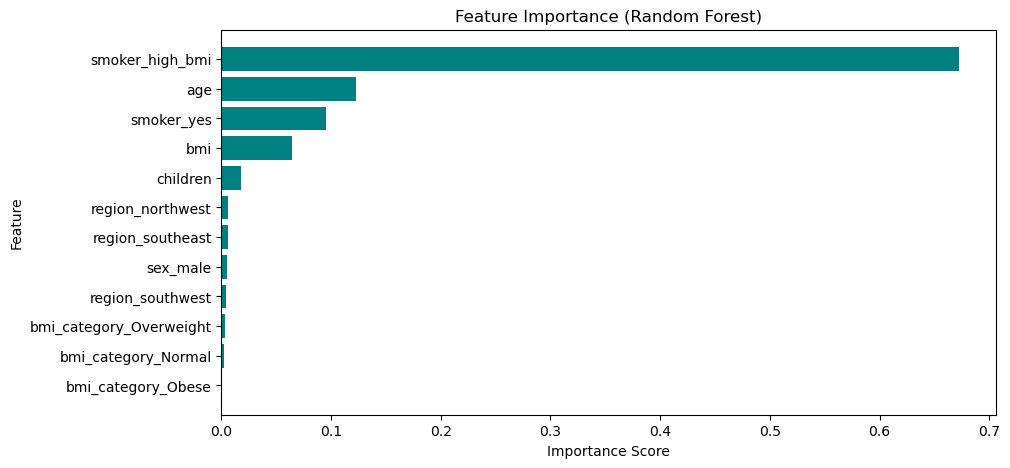

In [18]:
feature_importances = models["Random Forest"].feature_importances_
feature_importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="teal")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance (Random Forest)")
plt.gca().invert_yaxis()
plt.show()

In [19]:
param_grid = {
    "n_estimators": [50, 100, 200],  # Number of trees
    "max_depth": [None, 10, 20],  # Depth of trees
    "min_samples_split": [2, 5, 10]  # Minimum samples
}
rf = RandomForestRegressor(random_state=42)
# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)
# Fit the model
grid_search.fit(X_train, y_train)
# Get the best parameters
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


In [20]:
best_rf = RandomForestRegressor(
    max_depth=20,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)
best_rf.fit(X_train, y_train)
y_pred_optimized = best_rf.predict(X_test)

In [21]:
print(f"\nOptimized Random Forest Performance:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_optimized):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_optimized):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred_optimized):.2f}")


Optimized Random Forest Performance:
MAE: 607.95
MSE: 1981363.03
R² Score: 0.99


Slightly Lower MAE & MSE:
The model is more precise, making slightly better predictions.
Small but meaningful improvement—which matters in real-world applications.

R² Score is still very high (0.99):
The model explains almost all the variance in insurance costs.
I have likely hit an optimal level of performance with this dataset.

In [22]:
import joblib
joblib.dump(best_rf, "insurance_cost_model.pkl")

['insurance_cost_model.pkl']

In [23]:
pip install streamlit

Note: you may need to restart the kernel to use updated packages.


Mean Absolute Error (MAE): $607.95
Mean Squared Error (MSE): $1,981,363.03
Root Mean Squared Error (RMSE): $1,407.61
R-squared (R²): 0.9857


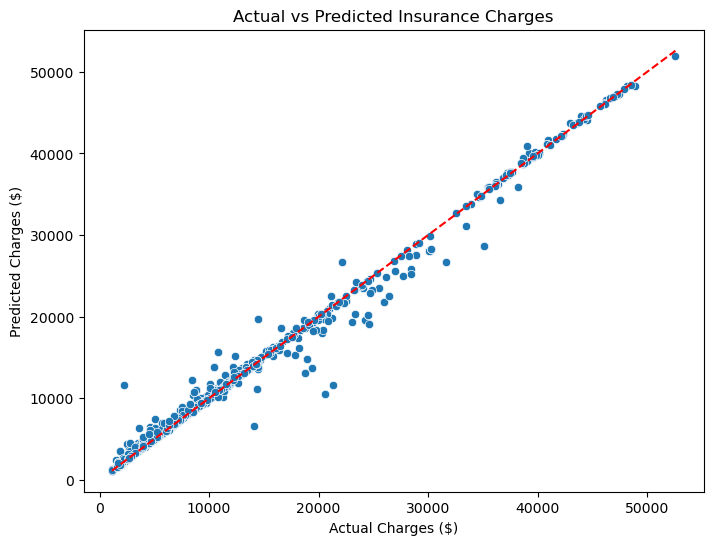

In [26]:
model = joblib.load("insurance_cost_model.pkl")
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Manual square root for RMSE
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
print(f"Mean Squared Error (MSE): ${mse:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")
print(f"R-squared (R²): {r2:.4f}")

# Plot Actual vs Predicted Values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Charges ($)")
plt.ylabel("Predicted Charges ($)")
plt.title("Actual vs Predicted Insurance Charges")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.show()
